<a href="https://colab.research.google.com/github/hyunsoo41/Deep-Learning-Project/blob/main/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [2]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.4.1
/device:GPU:0


In [3]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 17087, done.
remote: Counting objects: 100% (1622/1622), done.
remote: Compressing objects: 100% (831/831), done.
remote: Total 17087 (delta 969), reused 1316 (delta 741), pack-reused 15465
Receiving objects: 100% (17087/17087), 25.41 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (9302/9302), done.


In [4]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [5]:
# Download data and extract it to folder
get_data_extract()

4996284416/4996278331 [==============================] - 502s 0us/step
Dataset downloaded and extracted!


In [6]:
# Check the extracted dataset folder
os.listdir('food-101/')

['license_agreement.txt', 'meta', 'README.txt', 'images']

In [7]:
os.listdir('food-101/images')

['nachos',
 'takoyaki',
 'falafel',
 'seaweed_salad',
 'churros',
 'foie_gras',
 'eggs_benedict',
 'baby_back_ribs',
 'deviled_eggs',
 'oysters',
 'french_toast',
 'tuna_tartare',
 'steak',
 'tacos',
 'sashimi',
 'pancakes',
 'lobster_roll_sandwich',
 'hot_dog',
 'club_sandwich',
 'prime_rib',
 'ceviche',
 'hot_and_sour_soup',
 'bread_pudding',
 'fish_and_chips',
 'mussels',
 'huevos_rancheros',
 'greek_salad',
 'scallops',
 'ravioli',
 'paella',
 'beignets',
 'caprese_salad',
 'gyoza',
 'cheesecake',
 'chicken_quesadilla',
 'macarons',
 'apple_pie',
 'pulled_pork_sandwich',
 'baklava',
 'bruschetta',
 'samosa',
 'shrimp_and_grits',
 'french_fries',
 'spring_rolls',
 'cheese_plate',
 'french_onion_soup',
 'dumplings',
 'cup_cakes',
 'tiramisu',
 'grilled_cheese_sandwich',
 'ice_cream',
 'chicken_curry',
 'cannoli',
 'spaghetti_bolognese',
 'sushi',
 'poutine',
 'spaghetti_carbonara',
 'fried_calamari',
 'filet_mignon',
 'red_velvet_cake',
 'caesar_salad',
 'carrot_cake',
 'chicken_wing

In [8]:
os.listdir('food-101/meta')

['train.json',
 'train.txt',
 'classes.txt',
 'test.txt',
 'test.json',
 'labels.txt']

In [9]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [10]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


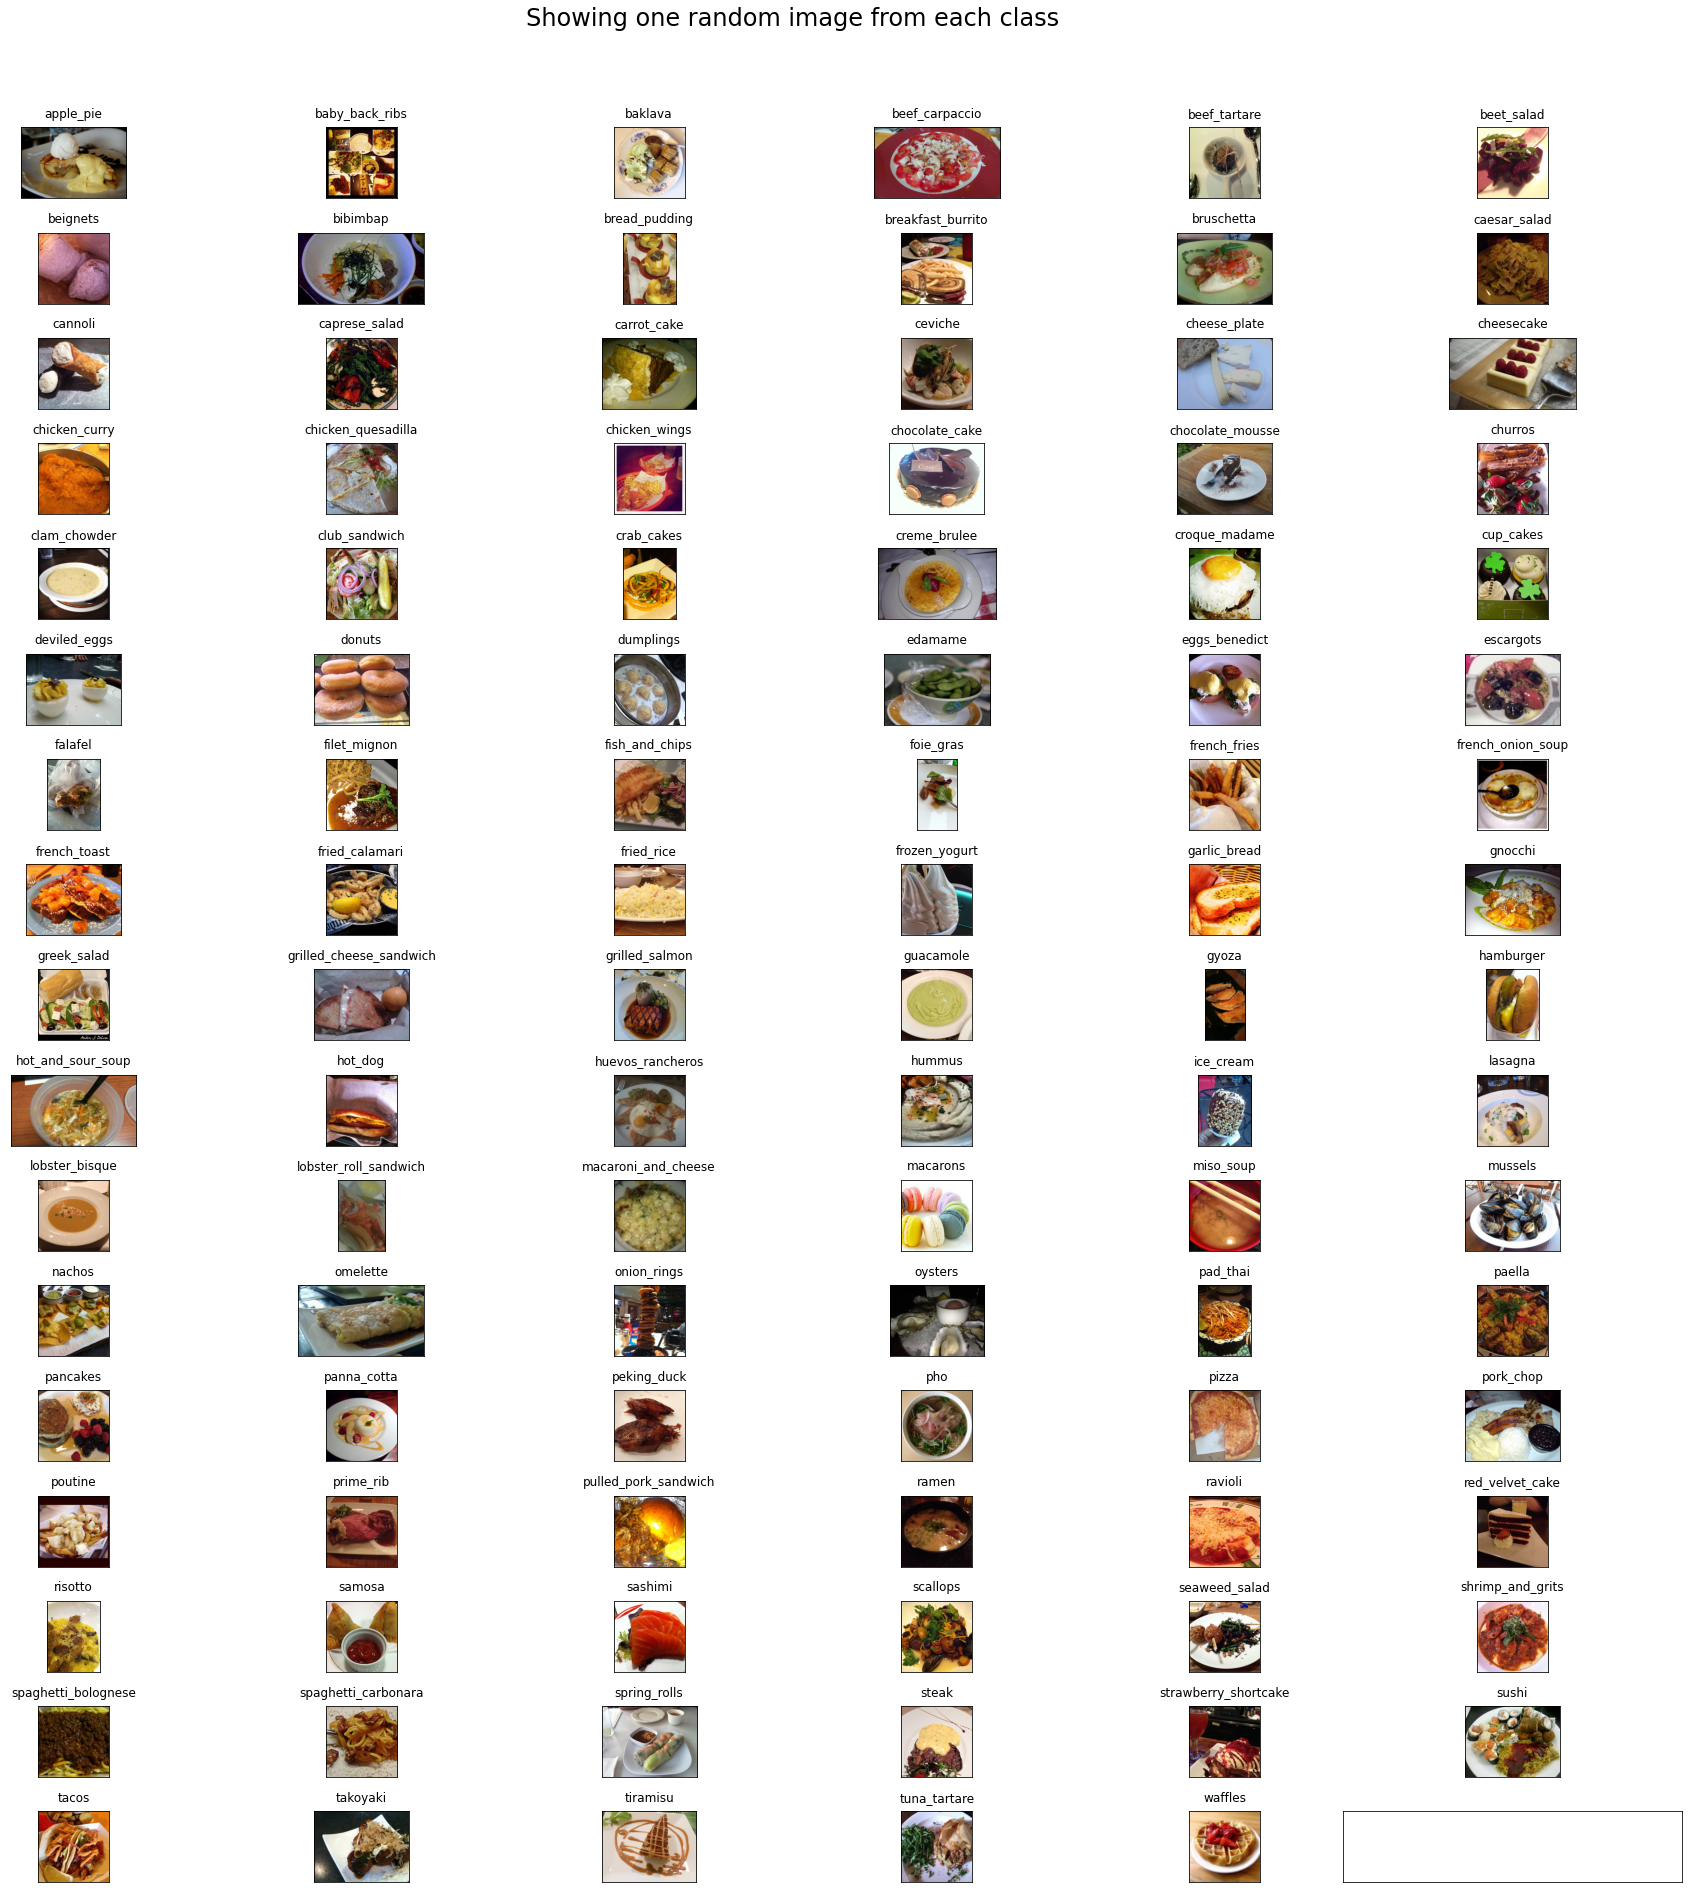

In [11]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

In [12]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [13]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [14]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [15]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [16]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


In [17]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [18]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich

In [19]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [20]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [21]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [22]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
2250


In [23]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [24]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
750


In [25]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'food-101/train_mini'
  validation_data_dir = 'food-101/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [26]:
# Train the model with data from 3 classes
n_classes = 3
epochs = 5
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
87916544/87910968 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
140/140 [==============================] - 140s 700ms/step - loss: 1.1446 - accuracy: 0.4006 - val_loss: 0.8737 - val_accuracy: 0.6957

Epoch 00001: val_loss improved from inf to 0.87373, saving model to bestmodel_3class.hdf5
Epoch 2/5
140/140 [==============================] - 92s 652ms/step - loss: 0.9190 - accuracy: 0.6058 - val_loss: 0.7084 - val_accuracy: 0.7921

Epoch 00002: val_loss improved from 0.87373 to 0.70836, saving model to bestmodel_3class.hdf5
Epoch 3/5
140/140 [==============================] - 91s 651ms/step - loss: 0.7624 - accuracy: 0.7391 - val_loss: 0.5855 - val_accuracy: 0.8505

Epoch 00003: val_loss improved from 0.70836 to 0.58550, saving model to bestmodel_3class.hdf5
Epoch 4/5
140/140 [==============================] - 92s 652ms/step - loss: 0.6412 - accuracy: 0.7862 - val_loss: 0.4822 - val_accuracy: 0.8641

Epoch 00004: val_loss improved from 0.58550 to 0.48221, saving model to bestmodel_3class.hdf5
Epoch 5/5
140/140 [============================

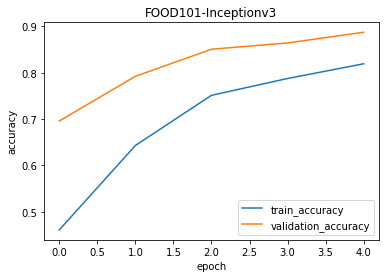

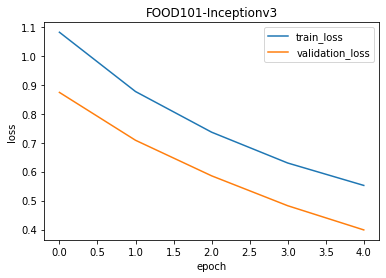

In [27]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) 
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [28]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_3class.hdf5',compile = False)

CPU times: user 2.91 s, sys: 119 ms, total: 3.03 s
Wall time: 2.99 s


레시피 파일 불러오기

In [29]:
from google.colab import files
file_uploaded = files.upload()

Saving apple_pie.txt to apple_pie.txt


In [36]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255                                     

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
        #레시피 출력
        if os.path.isfile('/content/%s.txt'%pred_value):
          with open('apple_pie.txt', 'r', encoding='utf8') as f: 
            print(f.read())

In [37]:
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg

--2021-05-13 14:17:26--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
Connecting to acleanbake.com (acleanbake.com)|138.197.203.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114276 (112K) [image/jpeg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>] 111.60K   411KB/s    in 0.3s    

2021-05-13 14:17:27 (411 KB/s) - ‘applepie.jpg’ saved [114276/114276]



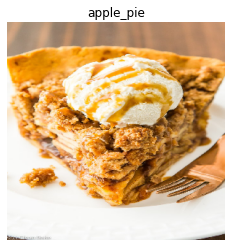

-애플파이 레시피-

재료
[파이]
박력분 200g
소금 1/8ts
설탕 5g
차가운 버터 100g
계란 1개
[사과필링]
사과2게
설탕 또는 황설탕 60g
버터 25g
옥수수전분 1Ts
계피가루 1/4ts
계란물(노른자1개+물1Ts)

준비해두세요
· 박력분은 체 쳐 둡니다.
· 버터는 냉장고에 두고 차갑게 해 콩알크기로 다져둡니다.
· 사과는 1cm크기로 깍뚝썰기 해 둡니다.

STEP 1 : (8분 소요 예상)
[파이]
박력분에 소금, 설탕을 넣고 섞은 뒤 버터를 넣고 도우블렌더로 잘 섞습니다.
(도우블렌더가 없으면 양손으로 비벼 고슬고슬하게 합니다)

STEP 2 : (5분 소요 예상)
가운데 홈을 파고 그 안에 계란을 넣은 뒤 손으로 치댑니다.

STEP 3 : (3분 소요 예상)
작업대로 옮겨 완전히 한덩어리가 되도록 합니다.
(너무 오래 치대지 않습니다)

STEP 4 : (60분 소요 예상)
반죽을 납작하게 하여 랩이나 비날에 싼 후 냉장실에 1시간 둡니다.

STEP 5 : (4분 소요 예상)
[필링]
냄비에 설탕을 넣고 중불에 녹인 후 버터를 넣어 잘 섞습니다.

STEP 6 : (10분 소요 예상)
버터가 녹으면 바로 사과를 넣고 바닥부분이 눌지 않도록 잘 저으며 졸입니다.
(중불에서 약10분정도)

STEP 7 : (3분 소요 예상)
어느정도 사과가 졸으면 전분과 계피가루를 넣고 2분정도 더 졸인 후 다른볼에 담아 식힙니다.

STEP 8 : (5분 소요 예상)
작업대에 비닐을 깔고 밀대를 이용하여 두께 약3mm정도로 밉니다.
(반죽이 질면 분량외 밀가루를 뿌려가며 밀어주세요)

STEP 9 : (5분 소요 예상)
팬위에 반죽을 올린 뒤 반죽을 최대한 밀착시키고 가장자리를 눌러 남은 반죽을 잘라내고 손가락으로 밀착시키면서 다듬습니다.

STEP 10 : (5분 소요 예상)
남은 반죽은 다시 3mm두께로 밀어 약1cm간격으로 자릅니다.

STEP 11 : (5분 소요 예상)
틀에 필링을 담고 가장자리에 물칠을 한 후 잘라 놓은 반죽을 격자로

In [38]:
# Make a list of images and test the trained model
images = []
images.append('applepie.jpg')
predict_class(model_best, images, True)